# projeto

dataset saved at [dropbox](https://www.dropbox.com/home/wds23s4_bwl_chartformation_dataset)

draft text at [share point](https://dhbwloerrachde-my.sharepoint.com/:w:/g/personal/salvadoc_dhbw-loerrach_de/EVaAuPh0o2NCkm2lsGT4WHMBiBt3HxajKn6lm9RDp4gK2g?e=Aq9khT)

# Library

In [ ]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd

import zipfile
import py7zr
import os

import yfinance as yf


## Machine Learning imports
# for data processing:

import tensorflow as tf
from sklearn.model_selection import train_test_split # pip install scikit-learn

# for CNN 1D model:
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping



# DATASET Hermaeus

data from [Hermeaus](https://github.com/Hermaeus1618/PatternRecognition)

... need to download by hand and unzip it! 

The usded file `"aaatemp/DATASET.zfs"` has been unziped already!

## Funs

### fun for extracting

In [3]:
def dataset_extract_from_zip(zip_path):
    """
    Extracts the dataset from a zip file and returns a DataFrame with the data.

    Data from https://github.com/Hermaeus1618/PatternRecognition
    
    Args:
        zip_path (str): Path to the zip file.
    
    Returns:
        pd.DataFrame: DataFrame containing the extracted data.
    """
    ZIP_PATH = zip_path


    if not os.path.exists(ZIP_PATH):
        raise FileNotFoundError(f"The file '{ZIP_PATH}' does not exist. Please check the file path.")


    data = []

    with zipfile.ZipFile(ZIP_PATH, "r") as zfile:
        # Ler todos os nomes de arquivos no ZIP
        filenames = [f.filename for f in zfile.infolist()]
    
        for fname in filenames:
            # Dividir o nome do arquivo em partes
            # Values are seprated by "_GAP_" string which can be easily converted back into list by pd.Series().str.split()
            # Naming convention for Numpy files: IOC_GAP_CupAndHandle_GAP_HOUR1_GAP_1722503700_GAP_1725272100 STOCK_GAP_PATTERN_GAP_TIMEFRAME_GAP_START_GAP_END
            parts = fname.split("_GAP_")
            if len(parts) != 5:
                print(f"Ignorando arquivo com formato inválido: {fname}")
                continue
            
            try:
                company, pattern, frequency, start, end = parts
                start = int(start)
                end = int(end)
            except ValueError as e:
                print(f"Erro ao converter start/end para inteiro no arquivo {fname}: {e}")
                continue
            
            # Ler os dados binários e convertê-los para um array Float64
            try:
                with zfile.open(fname) as file:
                    array = np.frombuffer(file.read(), dtype=np.float64)
                if array.size == 0:
                    print(f"Array vazio no arquivo {fname}. Ignorando.")
                    continue
            except Exception as e:
                print(f"Erro ao ler os dados binários do arquivo {fname}: {e}")
                continue
            
            # Adicionar os dados à lista
            data.append({
                "Company": company,
                "Pattern": pattern,
                "Frequency": frequency,
                "Start": start,
                "End": end,
                "Array": array
            })

    df = pd.DataFrame(data)

    return df

### fun for transformation

In [4]:
def calculate_time_range(row):
    """
    It is a complement to the dataset_extract_from_zip() function, that extracts the a specific data from:
    https://github.com/Hermaeus1618/PatternRecognition

    It dependes on the frequency of the data to calculate the time range, based on the start and end timestamps.
    It is used to create the time range for the data in the DataFrame.

    Simple check as follow:
    print(df["Frequency"].unique()) # ['DAILY' 'WEEKLY' 'MONTHLY' 'MIN5' 'MIN15' 'MIN30' 'HOUR1']
    ... where df is the DataFrame returned by dataset_extract_from_zip()
    
    Frequencies:
    - DAILY: Daily intervals
    - WEEKLY: Weekly intervals
    - MONTHLY: Monthly intervals
    - MIN5: 5-minute intervals
    - MIN15: 15-minute intervals

    Args:
        row (pd.Series): A row from the DataFrame.
    Returns:
        pd.DatetimeIndex: A DatetimeIndex object representing the time range.

    Example:
        df = dataset_extract_from_zip("path/to/your/file.zip")
        df["TimeRange"] = df.apply(calculate_time_range, axis=1)
        print(df[["Company", "Pattern", "Frequency", "TimeRange"]])
    """


    frequency = row["Frequency"]
    start = row["Start"]
    end = row["End"]

    # ['DAILY' 'WEEKLY' 'MONTHLY' 'MIN5' 'MIN15' 'MIN30' 'HOUR1']
    
    if frequency == "DAILY":        
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                             end=pd.to_datetime(end, unit="s"), 
                             freq="D")
    
    elif frequency == "WEEKLY":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                             end=pd.to_datetime(end, unit="s"), 
                             freq="W")
    
    elif frequency == "MONTHLY":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                                end=pd.to_datetime(end, unit="s"), 
                                freq="M")

    elif frequency == "MIN5":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                             end=pd.to_datetime(end, unit="s"), 
                             freq="5T")
    
    elif frequency == "MIN15":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                                end=pd.to_datetime(end, unit="s"), 
                                freq="15T")
    elif frequency == "MIN30":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                                end=pd.to_datetime(end, unit="s"), 
                                freq="30T")
    
    elif frequency == "HOUR1":
        return pd.date_range(start=pd.to_datetime(start, unit="s"), 
                            end=pd.to_datetime(end, unit="s"), 
                            freq="H")
    else:
        print(f"Unknown frequency: {frequency}")
        return None

In [5]:
def calculate_time_range_per_row(row):
    """
    It is a complement to the dataset_extract_from_zip() function, that extracts the a specific data from:
    https://github.com/Hermaeus1618/PatternRecognition

    It dependes on the frequency of the data to calculate the time range, based on the start and end timestamps.
    It is used to create the time range for the data in the DataFrame.

    Simple check as follow:
    print(df["Frequency"].unique()) # ['DAILY' 'WEEKLY' 'MONTHLY' 'MIN5' 'MIN15' 'MIN30' 'HOUR1']
    ... where df is the DataFrame returned by dataset_extract_from_zip()
    
    Frequencies:
    - DAILY: Daily intervals
    - WEEKLY: Weekly intervals
    - MONTHLY: Monthly intervals
    - MIN5: 5-minute intervals
    - MIN15: 15-minute intervals

    Args:
        row (pd.Series): A row from the DataFrame.
    Returns:
        pd.DatetimeIndex: A DatetimeIndex object representing the time range.

    Example:
        df = dataset_extract_from_zip("path/to/your/file.zip")
        df["TimeRange"] = df.apply(calculate_time_range, axis=1)
        print(df[["Company", "Pattern", "Frequency", "TimeRange"]])
    """


    frequency = row["Frequency"]
    start = row["Start"]
    end = row["End"]

    try: # Validation
        start = int(start)
        end = int(end)        
        if start <= 0 or end <= 0 or start >= end:
            print(f"invalid values: start={start}, end={end}")
            return (None, None, None)           
    except ValueError as e:
        print(f"Error by convering start/end to int: {e}")
        return (None, None, None)
        
    start=pd.to_datetime(start, unit="s")
    end=pd.to_datetime(end, unit="s")    
    
    freq_map = {
    "DAILY": "D",
    "WEEKLY": "W",
    "MONTHLY": "ME",
    "MIN5": "5min",
    "MIN15": "15min",
    "MIN30": "30min",
    "HOUR1": "h"
    }

    freq = freq_map.get(frequency)
    
    if freq:
        range = pd.date_range(start=start, end=end, freq=freq)
        return (start, end, range)
    else:
        print(f"Unknown frequency: {frequency}")
        return (start, end, None)

In [6]:
def is_candlestick_viable(row):
    """
    Avalia se é viável gerar OHLC (candlestick) a partir dos dados de um registro.

    Condições:
    - Frequência precisa ser subdiária (MIN5, MIN15, MIN30, HOUR1)
    - TimeRange precisa conter pelo menos 2 pontos por dia útil

    Retorna:
    - True se for possível gerar OHLC válido
    - False caso contrário
    """
    frequency = row.get("Frequency")
    time_range = row.get("TimeRange")

    if time_range is None or not isinstance(time_range, pd.DatetimeIndex):
        return False

    # Frequências subdiárias
    subdaily = ["MIN5", "MIN15", "MIN30", "HOUR1"]
    if frequency not in subdaily:
        return False

    # Contagem de pontos por dia
    counts_per_day = pd.Series(time_range).groupby(lambda x: x.date()).count()

    # Verifica se há pelo menos 2 pontos por dia (mínimo para OHLC)
    return counts_per_day.ge(2).any()


In [7]:
def array_per_row_normalization(row):
    """
    
    """
    array = row.get("Array")
    
    if array is None or not isinstance(array, np.ndarray):
        return None

    # Normalização
    min_val = np.min(array)
    max_val = np.max(array)
    
    if max_val == min_val:
        return None  # Evita divisão por zero
    
    normalized_array = (array - min_val) / (max_val - min_val)
    
    return normalized_array 

### fun for ploting

In [8]:
def plot_and_save_by_pattern_from_zipfile(zip_path, pattern_name, max_plots=None, dropbox_folder=None):
    """
    Extrahiert und speichert alle Plots für ein bestimmtes Muster aus einer ZIP-Datei.
    :param zip_path: Pfad zur ZIP-Datei
    :param pattern_name: Name des Musters, das extrahiert werden soll
    :param max_plots: Maximale Anzahl der Plots, die gespeichert werden sollen (None für alle)
    :param dropbox_folder: Zielordner für die gespeicherten Plots (None für aktuellen Ordner)

    Example:
    # Plots für die ersten 10 Dateien erstellen
        dataset_path_dropbox = r"C:\\Users\\...\\Dropbox\\wds23s4_bwl_chartformation_dataset"
        plot_and_save_all_by_pattern(ZIP_PATH, "HeadAndShoulder", max_plots=10, dropbox_folder=dataset_path_dropbox)
    """

    # Zielordner erstellen
    if dropbox_folder is not None:
        dataset_folder = os.path.join(dropbox_folder, pattern_name)
    
    os.makedirs(dataset_folder, exist_ok=True)

    with zipfile.ZipFile(zip_path, "r") as zfile:
        # Dateinamen und Metadaten extrahieren
        files = pd.Series([f.filename for f in zfile.infolist()])
        meta_df = files.str.split("_GAP_", expand=True)
        meta_df.columns = ["ticker", "pattern", "freq", "start_ts", "end_ts"]
        meta_df["filename"] = files

        # Filter auf gewünschtes Pattern
        subset = meta_df[meta_df["pattern"] == pattern_name]

        # Begrenzung der Anzahl der Plots
        if max_plots is not None:
            subset = subset.head(max_plots)

        for i, row in subset.iterrows():
            file = row["filename"]
            ticker = row["ticker"]
            try:
                with zfile.open(file) as f:
                    data = np.frombuffer(f.read(), dtype=np.float64)

                # Plot erstellen
                plt.figure(figsize=(8, 3))
                plt.plot(data, color="black")  # Linie in Schwarz
                plt.axis("off")  # Achsen ausblenden
                plt.tight_layout()

                # Dateiname sichern
                safe_ticker = ticker.replace("/", "_")
                filename = os.path.join(dataset_folder, f"{i:03d}_{safe_ticker}.png")
                plt.savefig(filename, bbox_inches="tight", pad_inches=0)
                plt.close()

            except Exception as e:
                print(f"Fehler bei der Verarbeitung von {file}: {e}")



In [9]:
def plot_and_save_by_pattern_from_df(df, pattern_name, max_plots=None, dropbox_folder=None, img_size=(224, 224), dpi=100):
    """
    Extraction and saving of all plots for a specific pattern from a Pandas DataFrame.
  
    The image are prepared to CNN models keeping the aspect ratio of 1:1 and the size of 224x224 pixels, it helps to train the model afterwards.
    The images are saved in the format: {i:04d}_{ticker}.png per folder {pattern_name}.

    Drobox folder is used to save the images, and share the results with the team.

    This function follows some key points for CNN models:
        * Always use fixed size images
        * Normalize either during image generation or via preprocessing layer. Use the `Array_norm` instead of Array!
        * Balance the number of samples per class (1:1 ratio) to avoid class bias
        * Save datasets in folder structure: dataset/ClassName/*.png
        * Start simple (e.g., black line on white background) before moving to complex inputs

    Args:
        :param df: Data Frame mit den Spalten "Pattern", "Array_norm", "Company"
        :param img_size: Größe der Bilder in Pixeln (z.B. 224x224).
        :param dpi: Auflösung der Bilder 
        :param pattern_name: Name des Musters, das extrahiert werden soll
        :param max_plots: Maximale Anzahl der Plots, die gespeichert werden sollen (None für alle)
        :param dropbox_folder: Zielordner für die gespeicherten Plots (None für aktuellen Ordner)

    Example:
    # Plots für die ersten 10 Dateien erstellen
    dataset_path_dropbox = "C:.../Dropbox/wds23s4_bwl_chartformation_dataset"
    plot_and_save_all_by_pattern(ZIP_PATH, "HeadAndShoulder", max_plots=10, dropbox_folder=dataset_path_dropbox)

    """
    if dropbox_folder is not None:
        dataset_folder = os.path.join(dropbox_folder, pattern_name)
        os.makedirs(dataset_folder, exist_ok=True)
    else:
        dataset_folder = os.getcwd()

    subset = df[df["Pattern"] == pattern_name]
    if max_plots is not None:
        subset = subset.head(max_plots)

    for i, row in subset.iterrows():
        ticker = str(row['Company'])
        data = row["Array_norm"]

        fig = plt.figure(figsize=(img_size[0]/dpi, img_size[1]/dpi), dpi=dpi)
        plt.plot(data, color="black", linewidth=2)
        plt.axis("off")
        plt.tight_layout(pad=0)

        filename = os.path.join(dataset_folder, f"{i:04d}_{ticker}.png")
        plt.savefig(filename, bbox_inches="tight", pad_inches=0)
        plt.close(fig)


In [10]:
def save_array_as_npy_by_pattern(df, pattern_name, max_files=None, output_folder=None, normalize_method="mean"):
    """
    Alternative to the plot_and_save_by_pattern_from_df() function, that saves time series arrays as normalized .npy files organized by pattern (class).
    The .npy files are saved in the format: {i:04d}_{ticker}.npy per folder {pattern_name}.
    This function is more efficient for training models that accept raw time series data, such as CNN models.
    It avoids the need to generate images, and is useful for training models that accept raw time series data.
    The simple plot and save as .png did by plot_and_save_by_pattern_from_df() converts pixels values to 0-255 and looses the original data range.
    Moreover, it will require more disk space, time for saving and loading, and is not suitable for models that expect raw time series data, i.e. CNN models will retransform the image back to process it.
    The only advantage of the plot_and_save_by_pattern_from_df() is that it can be used to visualize the data, but it is not necessary for training models.

    Args:
        :param df (pd.DataFrame): DataFrame containing the time series data.
        The DataFrame should have the following columns:
        - "Pattern": name pattern (class) of the time series.
        - "Array": numpy array of the time series data.
        - "Company": name of the company (optional, can be used to create unique filenames).
        The DataFrame can be created by the dataset_extract_from_zip() function, which extracts the data from a zip file.
        :param pattern_name (str): Name of the pattern (class) to filter the DataFrame.
        :param max_files (int or None): Maximum number of files to save. If None, saves all files.
        :param output_folder (str or None): Root path to save the .npy files. If None, saves in the current working directory.
        :param normalize_method (str): Normalization method to apply to the time series data. The options are:
        - "mean": Normalizes the data by dividing by the mean value.
        - "minmax": Normalizes the data to the range [0, 1] using min-max scaling.
    Returns:
        None. The function saves the .npy files in the specified output folder.
      
    Example:
    # Save the first 10 files of the "HeadAndShoulder" pattern as .npy files
    dataset_path_dropbox = "C:.../Dropbox/chartformation_dataset"
    df = dataset_extract_from_zip("path/to/your/file.zip")
    save_array_as_npy_by_pattern(df, "HeadAndShoulder", max_files=10, output_folder=dataset_path_dropbox, normalize_method="mean")

    """
    if output_folder is None:
        output_folder = os.getcwd()
    
    pattern_folder = os.path.join(output_folder, pattern_name)
    os.makedirs(pattern_folder, exist_ok=True)

    subset = df[df["Pattern"] == pattern_name]
    if max_files:
        subset = subset.head(max_files)

    for i, row in subset.iterrows():
        array = np.array(row["Array"], dtype=np.float32)
        company = str(row.get("Company", "unknown")).replace("/", "_")

        # Normalization
        if normalize_method == "mean":
            mean = np.mean(array)
            if mean != 0:
                array = array / mean
        elif normalize_method == "minmax":
            min_val, max_val = np.min(array), np.max(array)
            if max_val > min_val:
                array = (array - min_val) / (max_val - min_val)

        filename = os.path.join(pattern_folder, f"{i:04d}_{company}.npy")
        np.save(filename, array)


#### OHLC + Candlestick 

IMPORTANT REQUIRMENT --> the data need info OLHC!

(open, low, high, close): share price (low and high) for each day at the time of opining and close the markt exchange. 

The [data](https://github.com/Hermaeus1618/PatternRecognition) of has only start and end for differnt time span (e.g., 15 min).
Even for longer time span (e.g. days), has only one price/day.
see object `dataset01_df` below.

There are some alternatives to OHLC with this data:
+ selecting time span with time resolutoin '< day'. For those with longer series with many days, group by day: O = min(time), L=min(price), H=max(price), C = max(time)! ... see function `is_candlestick_viable()` was create for this check!
+ recolect data form yahoo finance based on day/time for each share. However, it will reduce the sample size per chart formation, because not all has data for classification and no garantee which sub set is the chart.

    **... conclusion... no garantee if it would work!**

    **... only after OLHC, plot candle!**

<span sytyle="color:red">[not implmented yet] ... only to remember the function</span>

mpl = library [mplfinance](https://github.com/matplotlib/mplfinance), it is a kind of matplotlib based library for finance data, important for Candle plots! 

see also:

* Plotly: https://plotly.com/python/time-series/  

* Plotly Candlechart: https://plotly.com/python/candlestick-charts/  

```python
# Ensure the index is a DatetimeIndex
df = df.set_index("Start")

# Filter rows where the "Array" column has exactly 4 elements (OHLC data)
df = df[df["Array"].apply(lambda x: len(x) == 4)]

# Extract the required columns for candlestick plotting
# Assuming the "Array" column contains OHLC data in the order [Open, High, Low, Close]
ohlc_data = pd.DataFrame(df["Array"].tolist(), index=df.index, columns=["Open", "High", "Low", "Close"])

# Plot the data
mpf.plot(
    ohlc_data[-50:], 
    type='candle', 
    style='charles', 
    figsize=(3, 3),
    axisoff=True,
    savefig='images/DoubleTop/sample_001.png'
)
```

### fun for .npy

data saved on disk + padding 

In [11]:
def load_npy_dataset(root_folder):
    X = []
    y = []
    label_names = sorted(os.listdir(root_folder))  # Garantir ordem consistente
    label_map = {name: idx for idx, name in enumerate(label_names)}

    for label_name in label_names:
        label_path = os.path.join(root_folder, label_name)
        for fname in os.listdir(label_path):
            if fname.endswith(".npy"):
                fpath = os.path.join(label_path, fname)
                array = np.load(fpath)
                X.append(array)
                y.append(label_map[label_name])

    return X, y, label_map


In [12]:
def pad_sequences(X, target_len=None):
    """
    Pads sequences to the same length.

    Args:
        X (list of np.ndarray): List of sequences (numpy arrays) to be padded.
        target_len (int, optional): Length to which all sequences should be padded. 
                                    If None, it will use the length of the longest sequence.
 
    """
    if target_len is None:
        target_len = max(len(x) for x in X)

    padded_X = np.array([np.pad(x, (0, target_len - len(x))) for x in X])
    return padded_X


## DATA

#### data frame complete (raw)

In [13]:
dataset01_path_zip = "aaatemp/DATASET.zfs"
dataset01_df = dataset_extract_from_zip(dataset01_path_zip)

start_list, end_list, time_range_list = [], [], []
for index, row in dataset01_df.iterrows():
    start, end, time_range = calculate_time_range_per_row(row)
    start_list.append(start)
    end_list.append(end)
    time_range_list.append(time_range)

dataset01_df["StartDate"] = start_list # pd.to_datetime(dataset01_df["Start"], unit="s")
dataset01_df["EndDate"] = end_list #pd.to_datetime(dataset01_df["End"], unit="s")
dataset01_df["TimeRange"] = time_range_list # pd.to_datetime(dataset01_df["Start"], unit="s")
dataset01_df["Array_norm"] = dataset01_df["Array"].apply(lambda x: x/np.mean(x) if isinstance(x, np.ndarray) else x)
dataset01_df["ArrayLength"] = dataset01_df["Array"].apply(len)
dataset01_df["ArrayMedian"] = dataset01_df["Array"].apply(lambda x: np.median(x))

discrepancies = dataset01_df[dataset01_df["ArrayLength"] != dataset01_df["TimeRange"].apply(len)]
if not discrepancies.empty:
    print("Discrepâncias encontradas entre ArrayLength e TimeRange:")
    print(discrepancies[["Company", "Pattern", "ArrayLength", "TimeRange"]])

print(dataset01_df.shape)
print(dataset01_df.head())

Discrepâncias encontradas entre ArrayLength e TimeRange:
          Company            Pattern  ArrayLength  \
0       AXISCADES  AscendingTriangle           82   
1        BOSCHLTD  AscendingTriangle           18   
2       CELLPOINT  AscendingTriangle            9   
3          CHAVDA  AscendingTriangle          114   
4            DHTL  AscendingTriangle           17   
...           ...                ...          ...   
59027        LTIM  DoubleTopInitiate           56   
59028   MAXHEALTH  DoubleTopInitiate           15   
59029         ACC        RoundingTop           14   
59030  ADANIENSOL        RoundingTop           21   
59031  APOLLOHOSP        RoundingTop           15   

                                               TimeRange  
0      DatetimeIndex(['2024-05-02', '2024-05-03', '20...  
1      DatetimeIndex(['2024-08-06', '2024-08-07', '20...  
2      DatetimeIndex(['2024-08-20', '2024-08-21', '20...  
3      DatetimeIndex(['2024-03-13', '2024-03-14', '20...  
4      Date

In [14]:
print(dataset01_df.groupby(["Pattern"]).size().sort_values(ascending=False)) 




Pattern
RectangleChannel                   3157
DescendingChannel                  2979
RoundingTop                        2889
RoundingBottom                     2862
AscendingTriangle                  2500
DoubleTopPotential                 2500
DoubleBottomInitiate               2441
DescendingTriangle                 2439
DoubleTopInitiate                  2431
DoubleBottomPotential              2425
RectangleChannelPotential          2353
SymmetricTriangle                  2161
AscendingChannelBD                 2027
DoubleBottom                       1907
DoubleTop                          1894
HeadAndShoulder                    1646
RectangleChannelBO                 1639
RectangleChannelBD                 1636
SymmetricTriangleBO                1631
AscendingTriangleBD                1538
DescendingChannelBD                1325
DescendingTriangleBD               1267
BullishFlag                        1251
ReverseHeadAndShoulder             1247
AscendingChannelBO              

In [15]:
print(dataset01_df.groupby(["Frequency"]).size().sort_values(ascending=False)) # ['DAILY' 'WEEKLY' 'MONTHLY' 'MIN5' 'MIN15' 'MIN30' 'HOUR1']

Frequency
HOUR1      13419
MIN30      12884
MIN15      11348
MIN5        9370
DAILY       7611
WEEKLY      3151
MONTHLY     1249
dtype: int64


<Axes: >

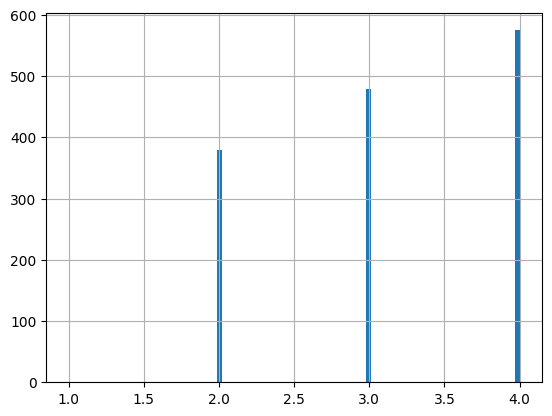

In [16]:
dataset01_df.loc[dataset01_df["ArrayLength"] < 5, "ArrayLength"].hist(bins=100)

  

In [17]:
# dataset01_df["IsCandlePossible"] = dataset01_df.apply(is_candlestick_viable, axis=1)


#### Header and Shoulder (HAS)

In [18]:
dataset01_df_has = dataset01_df.copy()
dataset01_df_has = dataset01_df_has[dataset01_df_has["Pattern"].str.contains("HeadAndShoulder")]
dataset01_df_has = dataset01_df_has[dataset01_df_has["ArrayLength"] > 6] # HAS need at leas 7 points
print(dataset01_df_has.shape)
print(dataset01_df_has.groupby(["Pattern"]).size().sort_values(ascending=False))

(4050, 12)
Pattern
HeadAndShoulder                    1590
ReverseHeadAndShoulder             1197
HeadAndShoulderPotential            779
ReverseHeadAndShoulderPotential     484
dtype: int64


In [19]:
print(dataset01_df_has.groupby("Pattern")["ArrayLength"].describe())

                                  count       mean        std  min   25%  \
Pattern                                                                    
HeadAndShoulder                  1590.0  43.035849  60.035048  7.0  20.0   
HeadAndShoulderPotential          779.0  51.860077  99.331194  7.0  22.0   
ReverseHeadAndShoulder           1197.0  41.639098  29.769910  7.0  21.0   
ReverseHeadAndShoulderPotential   484.0  41.698347  37.625427  7.0  19.0   

                                  50%   75%     max  
Pattern                                              
HeadAndShoulder                  29.0  54.0  2046.0  
HeadAndShoulderPotential         35.0  58.0  2324.0  
ReverseHeadAndShoulder           29.0  59.0   230.0  
ReverseHeadAndShoulderPotential  28.0  52.0   391.0  


In [20]:
def dataset_balanced(dataset):
    class_ref_name = dataset["Pattern"].value_counts().idxmin()
    class_ref_nmin = dataset["Pattern"].value_counts().min()
    class_ref_median = dataset[dataset["Pattern"]==class_ref_name]["ArrayLength"].median()

    dataset_sorted = dataset.copy()
    dataset_sorted["ref"] = [0 if dataset["Pattern"].iloc[x]==class_ref_name else 1 for x in range(len(dataset_sorted))]
    dataset_sorted["ref_dif"] = ((dataset_sorted["ArrayLength"] - class_ref_median)**2)**(1/2)
    dataset_sorted = dataset_sorted.sort_values(by=["ref", "Pattern", "ref_dif"])
    dataset_sorted = dataset_sorted.groupby("Pattern").head(class_ref_nmin).reset_index(drop=True)

    return dataset_sorted

In [21]:
def dataset_balanced_filtered(dataset, max_len=128):
    dataset_filtered = dataset[dataset["ArrayLength"] <= max_len].copy()
    class_ref_name = dataset_filtered["Pattern"].value_counts().idxmin()
    class_ref_nmin = dataset_filtered["Pattern"].value_counts().min()
    class_ref_median = dataset_filtered[dataset_filtered["Pattern"] == class_ref_name]["ArrayLength"].median()

    dataset_filtered["ref_dif"] = ((dataset_filtered["ArrayLength"] - class_ref_median) ** 2) ** 0.5
    dataset_filtered["ref"] = (dataset_filtered["Pattern"] != class_ref_name).astype(int)
    dataset_filtered = dataset_filtered.sort_values(by=["ref", "Pattern", "ref_dif"])
    dataset_balanced = dataset_filtered.groupby("Pattern").head(class_ref_nmin).reset_index(drop=True)
    return dataset_balanced

In [22]:
dataset01_df_has_balanced = dataset01_df_has.copy()
dataset01_df_has_balanced = dataset_balanced_filtered(dataset01_df_has_balanced, max_len=64)
print(dataset01_df_has_balanced.groupby("Pattern")["ArrayLength"].describe())

                                 count       mean        std   min    25%  \
Pattern                                                                     
HeadAndShoulder                  390.0  24.776923   2.510437  20.0  22.25   
HeadAndShoulderPotential         390.0  23.112821   7.368912  10.0  17.00   
ReverseHeadAndShoulder           390.0  24.728205   2.849791  18.0  22.00   
ReverseHeadAndShoulderPotential  390.0  27.405128  13.742770   7.0  18.00   

                                  50%   75%   max  
Pattern                                            
HeadAndShoulder                  26.0  27.0  28.0  
HeadAndShoulderPotential         23.0  29.0  38.0  
ReverseHeadAndShoulder           25.0  27.0  30.0  
ReverseHeadAndShoulderPotential  24.0  36.0  63.0  


### PLOT+SAVE

plot_and_save_by_pattern_from_zipfile()

plot_and_save_by_pattern_from_df()

Example:
```python
# Plots für die ersten 10 Dateien erstellen
dataset_path_dropbox = r"C:\Users\carlo\Dropbox\wds23s4_bwl_chartformation_dataset"
plot_and_save_by_pattern_from_zipfile(ZIP_PATH, "HeadAndShoulder", max_plots=10, dropbox_folder=dataset_path_dropbox)

# Call the function with the updated DataFrame
plot_and_save_by_pattern_from_df(dataset01_df, "TripleTop", max_plots=10, dropbox_folder=dataset_path_dropbox)
```


#### HAS

In [23]:
dataset_path_dropbox = r"C:\Users\carlo\Dropbox\wds23s4_bwl_chartformation_dataset"
dataset_path_dropbox_dataset = os.path.join(dataset_path_dropbox, "dataset")
dataset_path_dropbox_dataset_npy = os.path.join(dataset_path_dropbox, "dataset_npy")


has_dataset_run_again = True # just to control the execution and avoid multiple runs.  

if has_dataset_run_again:

    os.makedirs(dataset_path_dropbox_dataset, exist_ok=True)

    for pattern in dataset01_df_has_balanced["Pattern"].unique():
        #plot_and_save_by_pattern_from_df(dataset01_df_has, pattern, max_plots=508, dropbox_folder=dataset_path_dropbox_dataset)
        save_array_as_npy_by_pattern(dataset01_df_has_balanced, pattern, max_files=508, output_folder=dataset_path_dropbox_dataset_npy, normalize_method="mean")
        print(f"Pattern {pattern} processed and saved.")
        print("N files in folder:", len(os.listdir(os.path.join(dataset_path_dropbox_dataset_npy, pattern))))



Pattern ReverseHeadAndShoulderPotential processed and saved.
N files in folder: 390
Pattern HeadAndShoulder processed and saved.
N files in folder: 390
Pattern HeadAndShoulderPotential processed and saved.
N files in folder: 390
Pattern ReverseHeadAndShoulder processed and saved.
N files in folder: 390


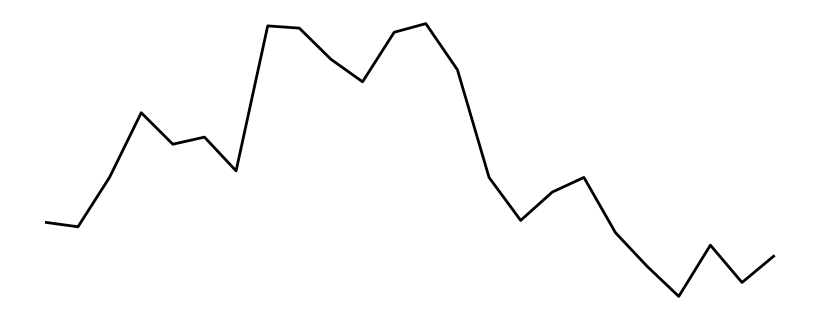

In [24]:
dataset01_df_has_test_plot_file = os.path.join(dataset_path_dropbox_dataset_npy, "HeadAndShoulder", "0391_TPLPLASTEH.npy")
dataset01_df_has_test_plot = np.load(dataset01_df_has_test_plot_file)

plt.figure(figsize=(8, 3))
plt.plot(dataset01_df_has_test_plot, color="black", linewidth=2)
plt.axis("off")
plt.tight_layout(pad=0)

# CNN 1D

* CNN 1D --> use data .npy!!!... need padding to set the size of array (Cons). Pros: quick, less memmory, use temporal series direct.

* CNN 2D --> use data .png!!!... don´t need padding (Pros!), because the plots (figure) are built with standart size and resolution.

## HAS
### data

In [25]:
print(dataset_path_dropbox_dataset_npy) # created above at "DATA" section!


has_len_target_array_total = []

for f in os.listdir(dataset_path_dropbox_dataset_npy):
    print(f,":", len(os.listdir(os.path.join(dataset_path_dropbox_dataset_npy, f))), "files .npy")
    has_len_target_array_class = []
    for f2 in os.listdir(os.path.join(dataset_path_dropbox_dataset_npy, f)):
        has_len_target_array_class.append(len(np.load(os.path.join(dataset_path_dropbox_dataset_npy, f, f2))))
    print("size 1D:\n",pd.Series(has_len_target_array_class).describe())
    has_len_target_array_total.append(has_len_target_array_class)



C:\Users\carlo\Dropbox\wds23s4_bwl_chartformation_dataset\dataset_npy
HeadAndShoulder : 390 files .npy
size 1D:
 count    390.000000
mean      24.776923
std        2.510437
min       20.000000
25%       22.250000
50%       26.000000
75%       27.000000
max       28.000000
dtype: float64
HeadAndShoulderPotential : 390 files .npy
size 1D:
 count    390.000000
mean      23.112821
std        7.368912
min       10.000000
25%       17.000000
50%       23.000000
75%       29.000000
max       38.000000
dtype: float64
ReverseHeadAndShoulder : 390 files .npy
size 1D:
 count    390.000000
mean      24.728205
std        2.849791
min       18.000000
25%       22.000000
50%       25.000000
75%       27.000000
max       30.000000
dtype: float64
ReverseHeadAndShoulderPotential : 390 files .npy
size 1D:
 count    390.000000
mean      27.405128
std       13.742770
min        7.000000
25%       18.000000
50%       24.000000
75%       36.000000
max       63.000000
dtype: float64


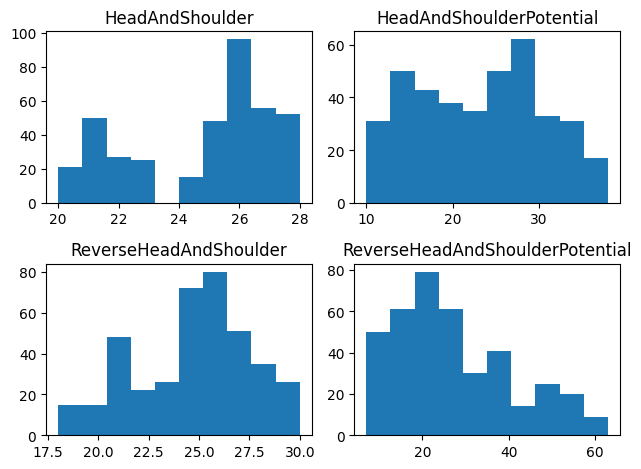

In [26]:
len(has_len_target_array_total)

fig, axs = plt.subplots(2, 2)
ax = axs.flatten()

for a in range(len(has_len_target_array_total)):
    ax[a].set_title(os.listdir(dataset_path_dropbox_dataset_npy)[a])
    ax[a].hist(has_len_target_array_total[a])
plt.tight_layout()

In [27]:
# pd.DataFrame(has_len_target_array_total).to_csv("aaatemp/has_len_target_array_total.csv", index=False, header=False)

### Load + Padding + Reshape + split

In [53]:
cnn1d_target_len = 64  # value after analyse! multiple of 8, less padding needed, more efficient for CNN 1D models

X_raw, y_raw, label_map = load_npy_dataset(dataset_path_dropbox_dataset_npy)
X_padded = pad_sequences(X_raw, target_len=cnn1d_target_len)  
X_padded = X_padded.reshape(-1, cnn1d_target_len, 1)
y = np.array(y_raw)

X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)




### Model Build: Sequential + Compile

In [54]:
# input shape and number of classes
input_shape = (cnn1d_target_len, 1)  # 1 means single channel (univariate time series x price). If it was OLHC data, it would be (cnn1d_target_len, 4) for Open, Low, High, Close.
num_classes = len(np.unique(y_train))  # number of unique labels

print(input_shape)
print(num_classes)

(64, 1)
4


In [55]:

model = Sequential([
    Input(shape=input_shape),

    Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Multiclass output
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # labels are integers, not one-hot
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 64, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 32, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 32, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,436 (540.77 KB)

 Trainable params: 138,244 (540.02 KB)

 Non-trainable params: 192 (768.00 B)

### Training (model.fit())

In [56]:
# early breacking setting to avoid overfitting
# This callback will stop training when a monitored metric has stopped improving.
# ... no improvements after 5 epochs.

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32, # X_train / batch_siez ~ 39!.. for this reason 39/39 batch size
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3757 - loss: 1.5985 - val_accuracy: 0.3397 - val_loss: 1.3435
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4063 - loss: 1.1812 - val_accuracy: 0.3910 - val_loss: 1.3231
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4505 - loss: 1.1107 - val_accuracy: 0.3846 - val_loss: 1.3006
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4109 - loss: 1.1306 - val_accuracy: 0.3910 - val_loss: 1.2700
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4546 - loss: 1.1104 - val_accuracy: 0.4423 - val_loss: 1.2591
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4442 - loss: 1.0906 - val_accuracy: 0.4359 - val_loss: 1.2278
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4515 - loss: 1.0955 - val_accuracy: 0.4551 - val_loss: 1.2041
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4846 - loss: 1.0659 - val_accuracy: 0.4551 - 

#### save model

In [70]:
models_path4save = "aaatemp/models"
model_cnn1d_v1_file = os.path.join(models_path4save, "chartformation_cnn1d_v1.keras") # better than .h5!

os.makedirs(models_path4save, exist_ok=True)

model.save(model_cnn1d_v1_file) 


### Model evaluation

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


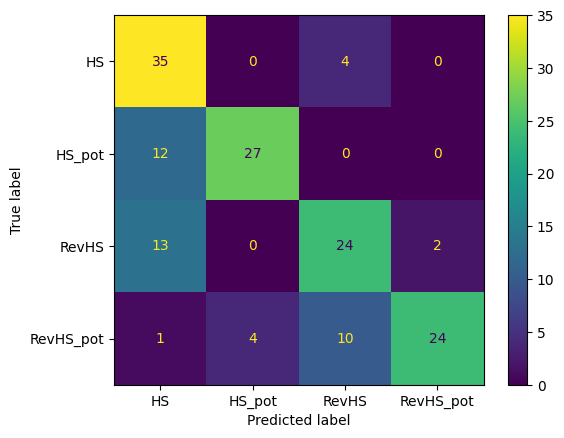

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred_test = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_test, axis=1)
model_confmatrix = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, display_labels=label_map.values())


model_confmatrix_df = pd.DataFrame(model_confmatrix, index=list(label_map.values()), columns=list(label_map.values()))

model_confmatrix_df.to_csv("aaatemp/models/chartformation_cnn1d_v1_confusion_matrix.csv")

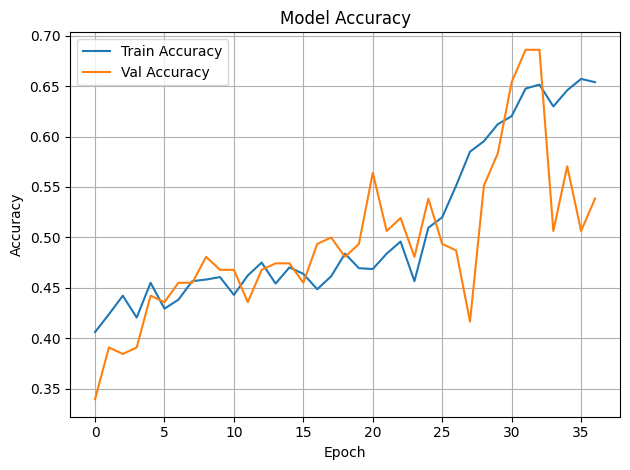

In [58]:
# training = validation with training data for learning
# validation = validation with validation (new = not seen!) data for generalization
# validation --> to check if the model is overfitting or not
# expect difference validation x training: good X bad learing, good x bad generalization...  overfitting if validation loss is higher than training loss, and validation accuracy is lower than training accuracy

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
model.evaluate(X_test, y_test) # X_test / 32 ~ 5 ... for this reason 5/5 batch size

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7138 - loss: 0.7273 


[0.7247698307037354, 0.7051281929016113]

# CNN 2D

* CNN 1D --> use data .npy!!!... need padding to set the size of array (Cons). Pros: quick, less memmory, use temporal series direct.

* CNN 2D --> use data .png!!!... don´t need padding (Pros!), because the plots (figure) are built with standart size and resolution.

# APPLICATION --> yahoo data

## funs

In [73]:
def sliding_windows(series, window_size=64, stride=1):
    X = []
    indices = []
    for i in range(0, len(series) - window_size + 1, stride):
        X.append(series[i:i+window_size])
        indices.append((i, i+window_size))
    return np.array(X), indices


## data

In [ ]:
aapl_ticker = yf.Ticker("AAPL")
aapl_hist = aapl_ticker.history(period="6mo", interval="1d")  # ou "60d", "1h", etc.

In [75]:
appl_series = aapl_hist["Close"].values.astype(np.float32)
appl_series_normalized = appl_series / np.mean(appl_series) # normalization. mean = the same method used in the dataset!

print(appl_series.shape)
print(aapl_hist.shape)
print(aapl_hist.head())

(124,)
(124, 7)
                                 Open        High         Low       Close  \
Date                                                                        
2024-12-18 00:00:00-05:00  251.553189  253.668083  247.143828  247.453079   
2024-12-19 00:00:00-05:00  246.904406  251.393577  246.495389  249.188889   
2024-12-20 00:00:00-05:00  247.443103  254.386361  245.098768  253.877594   
2024-12-23 00:00:00-05:00  254.156919  255.034791  252.840088  254.655716   
2024-12-24 00:00:00-05:00  254.875189  257.588630  254.675658  257.578674   

                              Volume  Dividends  Stock Splits  
Date                                                           
2024-12-18 00:00:00-05:00   56774100        0.0           0.0  
2024-12-19 00:00:00-05:00   60882300        0.0           0.0  
2024-12-20 00:00:00-05:00  147495300        0.0           0.0  
2024-12-23 00:00:00-05:00   40858800        0.0           0.0  
2024-12-24 00:00:00-05:00   23234700        0.0           0.

In [76]:
model_cnn1d_v1_from_file = load_model(model_cnn1d_v1_file)  # Load the model from file


X_windows, indices = sliding_windows(appl_series_normalized, window_size=64, stride=1)
X_windows = np.expand_dims(X_windows, axis=-1)  # required for CNN 1D

pred_probs = model.predict(X_windows)
pred_classes = np.argmax(pred_probs, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

d:\dhbw_s3\wds23s4_fibu_chartformation\venv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


In [77]:
threshold = 0.85
boxes = []
for i, prob in enumerate(pred_probs):
    class_id = np.argmax(prob)
    confidence = prob[class_id]
    if confidence >= threshold:
        boxes.append({
            "start": indices[i][0],
            "end": indices[i][1],
            "class": class_id,
            "confidence": confidence
        })


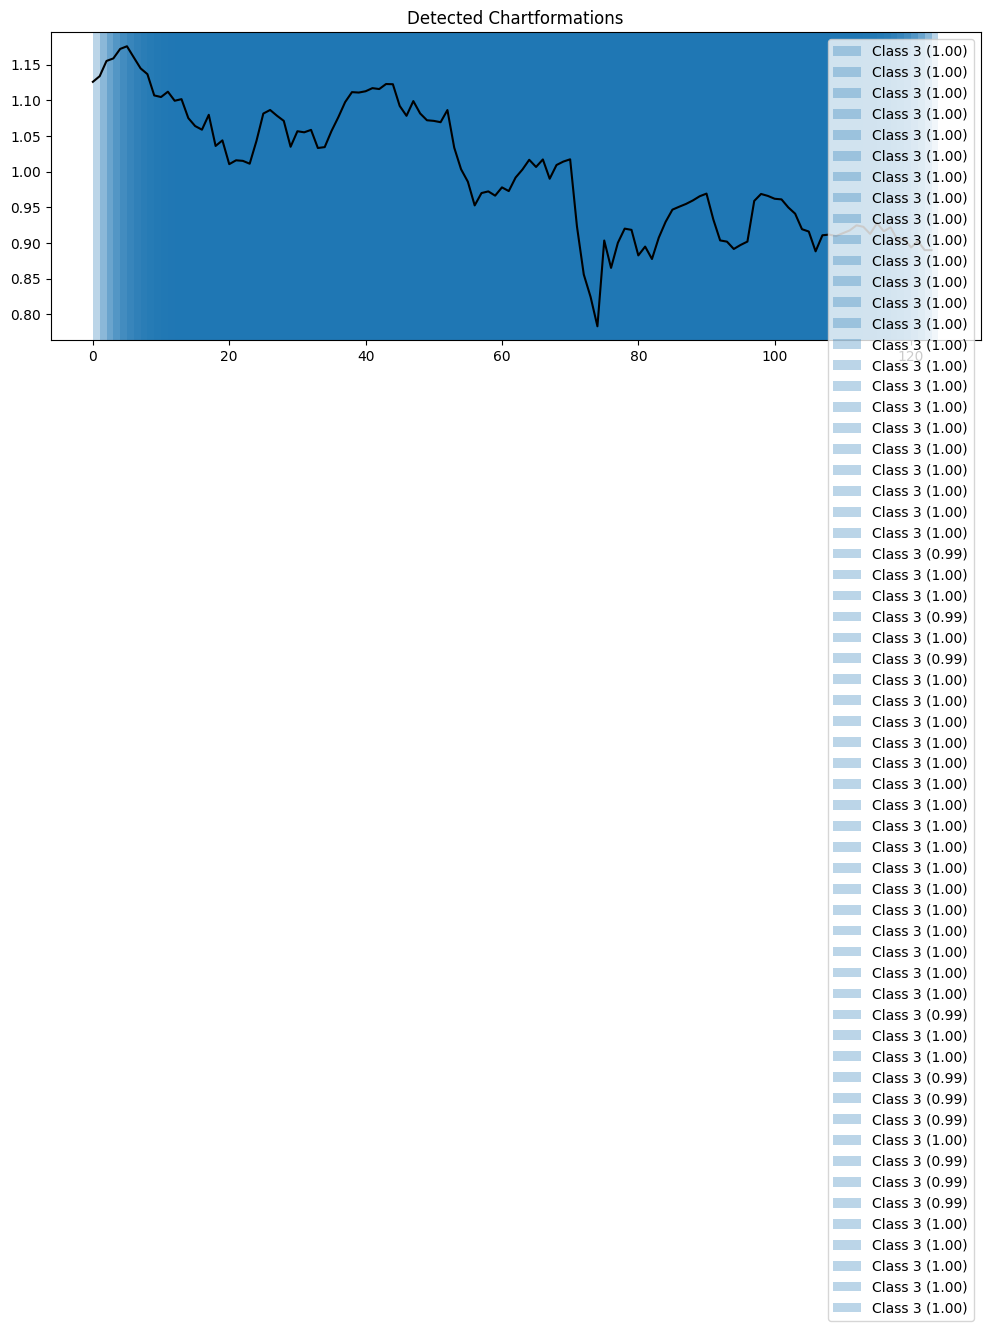

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(appl_series_normalized, color='black')

for box in boxes:
    plt.axvspan(box["start"], box["end"], alpha=0.3, label=f'Class {box["class"]} ({box["confidence"]:.2f})')

plt.title("Detected Chartformations")
plt.legend()
plt.show()


# MIS

## vs2

In [90]:
# --- Load and normalize Yahoo Finance data ---
def load_yahoo_series(ticker_symbol="AAPL", period="6mo", interval="1d"):
    ticker = yf.Ticker(ticker_symbol)
    hist = ticker.history(period=period, interval=interval)
    close_series = hist["Close"].values.astype(np.float32)
    normalized = close_series / np.mean(close_series)  # same normalization as used in training
    return normalized, hist.index

# --- Create sliding windows ---
def sliding_windows(series, window_size=64, stride=1):
    X = []
    indices = []
    for i in range(0, len(series) - window_size + 1, stride):
        X.append(series[i:i + window_size])
        indices.append((i, i + window_size))
    return np.array(X), indices

# --- Merge overlapping detections (NMS-like) ---
def merge_boxes(boxes, iou_threshold=0.5):
    merged = []
    boxes = sorted(boxes, key=lambda x: x['conf'], reverse=True)
    while boxes:
        current = boxes.pop(0)
        merged.append(current)
        boxes = [b for b in boxes if (b['end'] < current['start'] or b['start'] > current['end']) or
                 (min(current['end'], b['end']) - max(current['start'], b['start'])) / (b['end'] - b['start']) < iou_threshold]
    return merged

# --- Label map to convert class indices to readable names ---
label_map = {
    0: 'HS',
    1: 'HS_pot',
    2: 'RevHS',
    3: 'RevHS_pot'
}

# --- Color palette per class ---
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # One distinct color per class

# --- Main detection pipeline ---
def detect_patterns_on_ticker(ticker="AAPL", window_size=64, threshold=0.9, model_path=None):
    print(f"[INFO] Loading data for: {ticker}")
    series, time_index = load_yahoo_series(ticker)

    print(f"[INFO] Creating sliding windows...")
    X_windows, idx_pairs = sliding_windows(series, window_size=window_size)
    X_windows = np.expand_dims(X_windows, axis=-1)

    print(f"[INFO] Loading trained model...")
    model = load_model(model_path)

    print(f"[INFO] Predicting windows...")
    probs = model.predict(X_windows, verbose=0)
    preds = np.argmax(probs, axis=1)

    boxes = []
    for i, (start, end) in enumerate(idx_pairs):
        conf = np.max(probs[i])
        class_id = preds[i]
        if conf >= threshold:
            boxes.append({
                "start": start,
                "end": end,
                "class": class_id,
                "conf": conf
            })

    print(f"[INFO] Found {len(boxes)} raw boxes, applying NMS...")
    merged_boxes = merge_boxes(boxes)

    print(f"[INFO] Final detections: {len(merged_boxes)}")
    for b in merged_boxes:
        start_idx = b['start']
        end_idx = min(b['end'], len(time_index) - 1)
        label = label_map.get(b['class'], f"Class {b['class']}")
        print(f"→ {label} | {time_index[start_idx]} to {time_index[end_idx]} | Conf: {b['conf']:.2f}")

    # Plot with highlights
    plt.figure(figsize=(14, 5))
    plt.plot(series, color='black')
    for b in merged_boxes:
        start_idx = b['start']
        end_idx = min(b['end'], len(time_index) - 1)
        label = label_map.get(b['class'], f"Class {b['class']}")
        plt.axvspan(start_idx, end_idx, alpha=0.3, color=colors[b['class']], label=f"{label} ({b['conf']:.2f})")

    plt.title(f"Chartformations Detected on {ticker}")
    plt.xlabel("Time Index")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


## vs1

In [88]:
# main_detection.py

# --- Load and normalize Yahoo Finance data ---
def load_yahoo_series(ticker_symbol="AAPL", period="6mo", interval="1d"):
    ticker = yf.Ticker(ticker_symbol)
    hist = ticker.history(period=period, interval=interval)
    close_series = hist["Close"].values.astype(np.float32)
    normalized = close_series / np.mean(close_series) # the same normalization method used in the training's dataset!
    return normalized, hist.index

# --- Create sliding windows ---
def sliding_windows(series, window_size=64, stride=1):
    X = []
    indices = []
    for i in range(0, len(series) - window_size + 1, stride):
        X.append(series[i:i + window_size])
        indices.append((i, i + window_size))
    return np.array(X), indices

# --- Merge overlapping detections (NMS-like) ---
def merge_boxes(boxes, iou_threshold=0.5):
    merged = []
    boxes = sorted(boxes, key=lambda x: x['conf'], reverse=True)
    while boxes:
        current = boxes.pop(0)
        merged.append(current)
        boxes = [b for b in boxes if (b['end'] < current['start'] or b['start'] > current['end']) or
                 (min(current['end'], b['end']) - max(current['start'], b['start'])) / (b['end'] - b['start']) < iou_threshold]
    return merged

# --- Main detection pipeline ---
def detect_patterns_on_ticker(ticker="AAPL", window_size=64, threshold=0.9, model_path=None):
    print(f"[INFO] Loading data for: {ticker}")
    series, time_index = load_yahoo_series(ticker)

    print(f"[INFO] Creating sliding windows...")
    X_windows, idx_pairs = sliding_windows(series, window_size=window_size)
    X_windows = np.expand_dims(X_windows, axis=-1)

    print(f"[INFO] Loading trained model...")
    #model = load_model(r"D:\dhbw_s3\wds23s4_fibu_chartformation\aaatemp\models\chartformation_cnn1d_v1.keras")
    model = load_model(model_path)

    print(f"[INFO] Predicting windows...")
    probs = model.predict(X_windows, verbose=0)
    preds = np.argmax(probs, axis=1)

    boxes = []
    for i, (start, end) in enumerate(idx_pairs):
        conf = np.max(probs[i])
        class_id = preds[i]
        if conf >= threshold:
            boxes.append({
                "start": start,
                "end": end,
                "class": class_id,
                "conf": conf
            })

    print(f"[INFO] Found {len(boxes)} raw boxes, applying NMS...")
    merged_boxes = merge_boxes(boxes)

    print(f"[INFO] Final detections: {len(merged_boxes)}")
    # for b in merged_boxes:
    #     print(f"→ Class {b['class']} | {time_index[b['start']]} to {time_index[b['end']]} | Conf: {b['conf']:.2f}")
    for b in merged_boxes:
        start_idx = b['start']
        end_idx = min(b['end'], len(time_index) - 1)  # Corrige o limite superior
        print(f"→ Class {b['class']} | {time_index[start_idx]} to {time_index[end_idx]} | Conf: {b['conf']:.2f}")


    # Plot with highlights
    plt.figure(figsize=(14, 5))
    plt.plot(series, color='black')
    for b in merged_boxes:
        #plt.axvspan(b['start'], b['end'], alpha=0.3, label=f"Class {b['class']} ({b['conf']:.2f})")
        start_idx = b['start']
        end_idx = min(b['end'], len(time_index) - 1)
        plt.axvspan(start_idx, end_idx, alpha=0.3, label=f"Class {b['class']} ({b['conf']:.2f})")

    plt.title(f"Chartformations Detected on {ticker}")
    plt.xlabel("Time Index")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


## TESTS

[INFO] Loading data for: AAPL
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...


d:\dhbw_s3\wds23s4_fibu_chartformation\venv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[INFO] Found 60 raw boxes, applying NMS...
[INFO] Final detections: 2
→ RevHS_pot | 2024-12-19 00:00:00-05:00 to 2025-03-26 00:00:00-04:00 | Conf: 1.00
→ RevHS_pot | 2025-02-14 00:00:00-05:00 to 2025-05-19 00:00:00-04:00 | Conf: 1.00


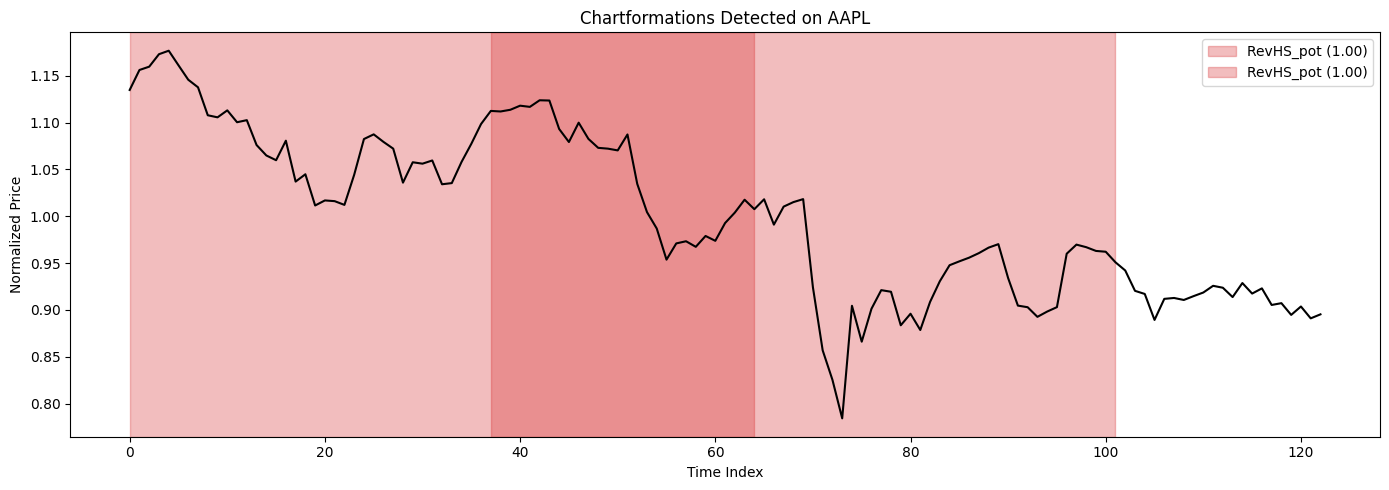

In [91]:
detect_patterns_on_ticker("AAPL", window_size=64, threshold=0.9, model_path=model_cnn1d_v1_file)  

[INFO] Loading data for: PETR4.SA
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...


d:\dhbw_s3\wds23s4_fibu_chartformation\venv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[INFO] Found 54 raw boxes, applying NMS...
[INFO] Final detections: 2
→ RevHS_pot | 2024-12-18 00:00:00-03:00 to 2025-03-26 00:00:00-03:00 | Conf: 1.00
→ RevHS_pot | 2025-02-07 00:00:00-03:00 to 2025-05-15 00:00:00-03:00 | Conf: 1.00


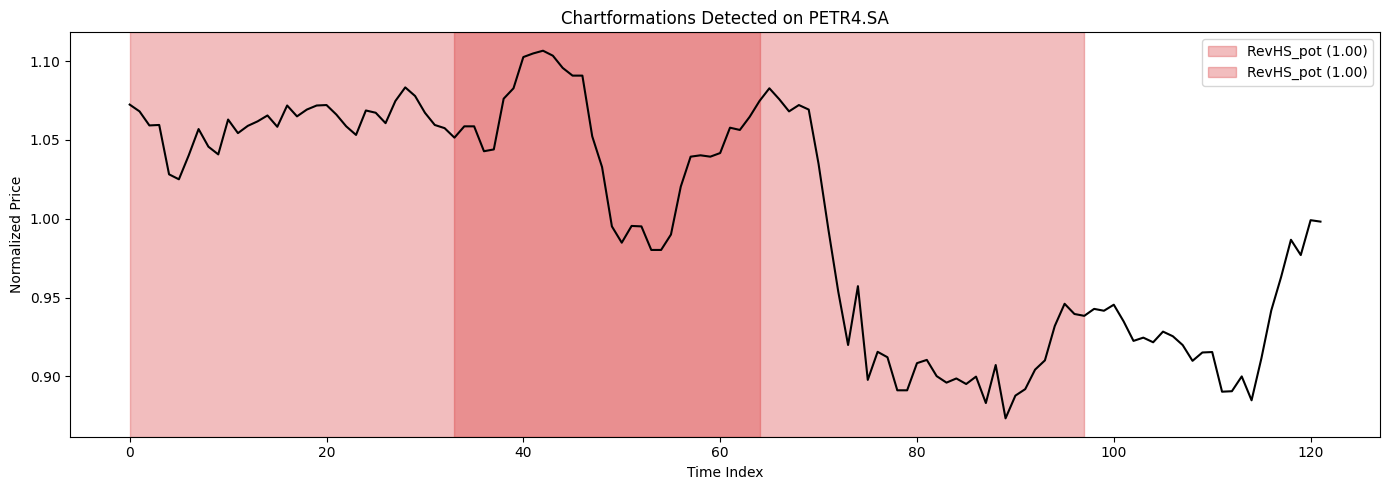

In [92]:
detect_patterns_on_ticker("PETR4.SA", window_size=64, threshold=0.9, model_path=model_cnn1d_v1_file)  

[INFO] Loading data for: MSFT
[INFO] Creating sliding windows...
[INFO] Loading trained model...
[INFO] Predicting windows...


d:\dhbw_s3\wds23s4_fibu_chartformation\venv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[INFO] Found 60 raw boxes, applying NMS...
[INFO] Final detections: 2
→ RevHS_pot | 2025-03-19 00:00:00-04:00 to 2025-06-18 00:00:00-04:00 | Conf: 1.00
→ RevHS_pot | 2025-01-15 00:00:00-05:00 to 2025-04-17 00:00:00-04:00 | Conf: 1.00


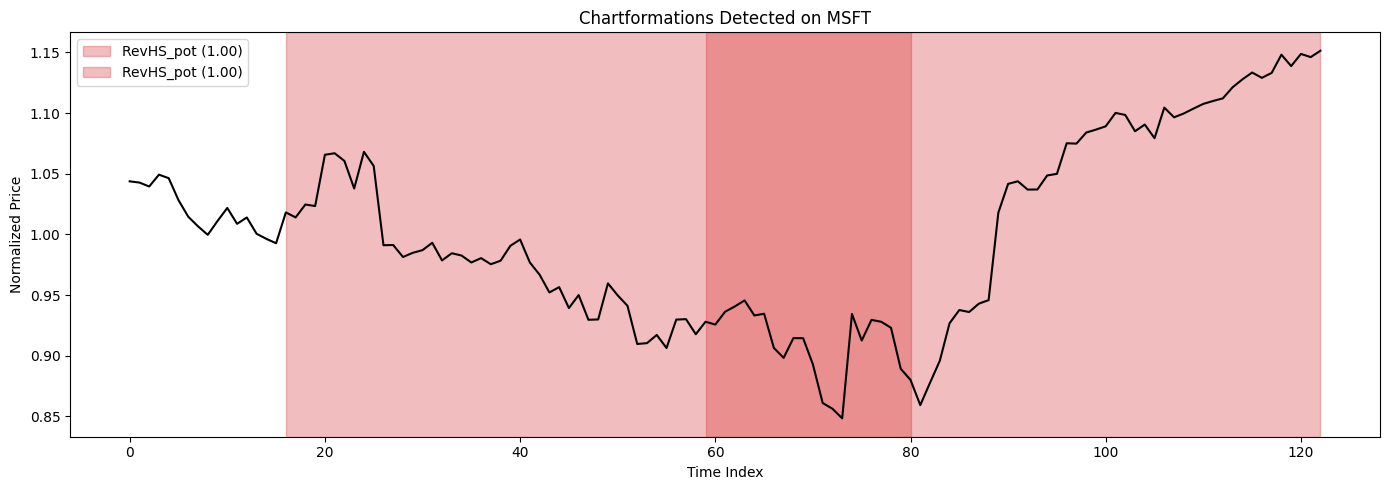

In [93]:
detect_patterns_on_ticker("MSFT", window_size=64, threshold=0.9, model_path=model_cnn1d_v1_file)  

